# Metropolis-Hasting MCMC

We calibrate the Heston model parameters with option price through a Markov Chain Monte-Carlo approach. 

The parameters to be calibrated are:
- **κ**: Mean reversion speed of variance  
- **θ**: Long-term mean of variance  
- **σ**: Volatility of variance (vol of vol)  
- **ρ**: Correlation between asset and variance  
- **v₀**: Initial variance  

Given these parameters, we can compute the theoretical option price. We define the likelihood function by assuming that the noise around the fair option prices are normally distributed. We use uninformative priors (uniform distributions) for the parameters, and sample their posterior distribution using MCMC.

#### Import

The logic for option pricing and MCMC are implemented in C++ for performance and exposed to Python using pybind11. 

A Python interface class (HestonCalibrator) manages interaction with the compiled module and handle functionality for visualization and parallelization to enhance performance. 

In [1]:
from src.py.heston_calibrator import HestonCalibrator
import numpy as np
import pandas as pd

#### Create test data

In [2]:
# Dummy market data
S0 = 100
kappa, theta, sigma, rho, v0 = 1.3, 0.1, 0.7, -0.2, 0.02  
model_params = [kappa, theta, sigma, rho, v0]

strikes = np.linspace(90, 110, 10)
maturities = np.linspace(0.5, 1.5, 10)
strike_grid, maturity_grid = np.meshgrid(strikes, maturities, indexing='ij')
strike_grid = strike_grid.flatten()
maturity_grid = maturity_grid.flatten()

market_prices = np.array([HestonCalibrator.call_price(S0, K, T, *model_params) for K, T in zip(strike_grid, maturity_grid)])
market_prices_df = pd.DataFrame(market_prices.reshape(10,10), index=strikes, columns=maturities)

#### Metropolis-Hasting MCMC

We run a single MCMC chain to monitor the burn-in period the density of the sampled distribution. Although the trace plot suggests convergence, the density is not really smooth and does not fit the true value well

In [7]:
# MCMC fitting
test_sample_params = [2, 0.05, 0.3, 0.2, 0.1]
MCMC = HestonCalibrator(market_prices_df)
res = MCMC.fit(initial_params=test_sample_params, n_iter=10000)

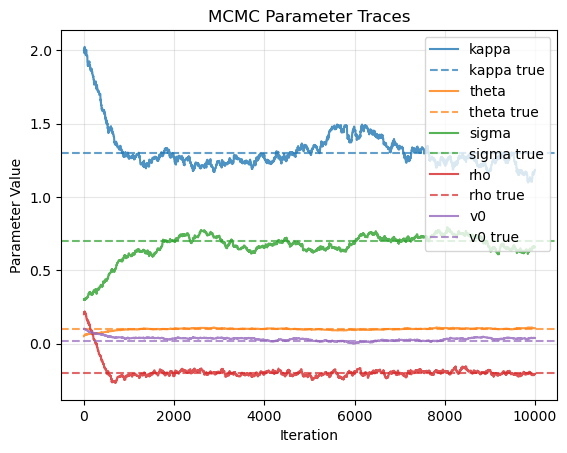

In [10]:
res.trace_plot(true_params=model_params, include_burn_in=True)

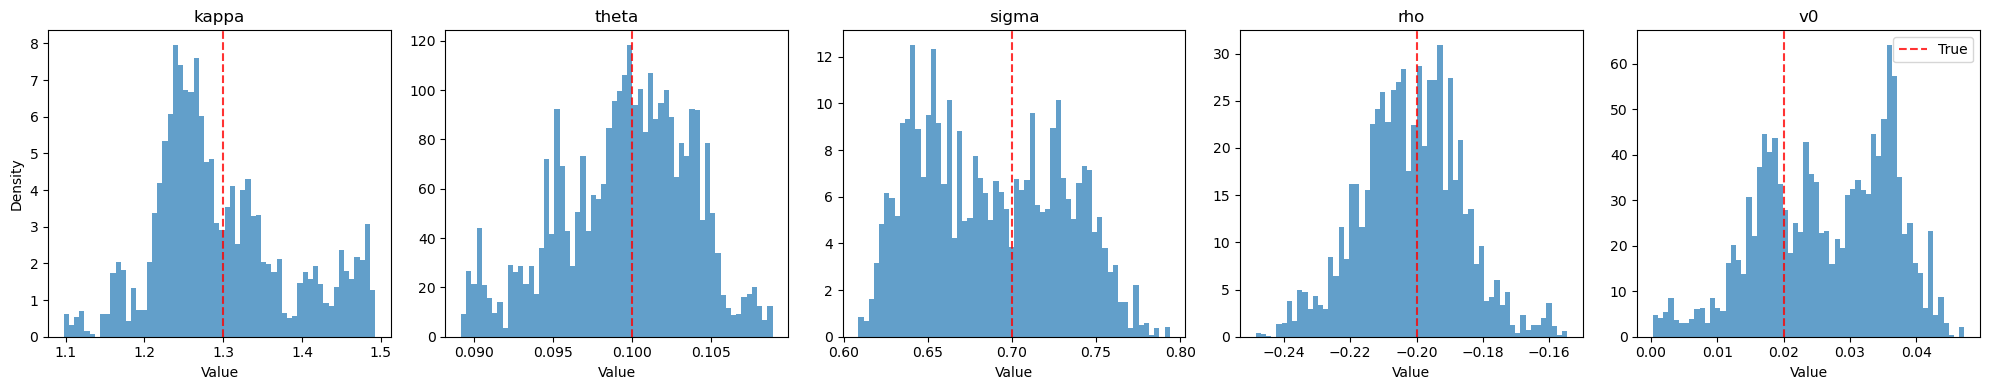

In [9]:
res.density_plot(true_params=model_params)

In [11]:
res.summary()

Average Acceptance Rate: 0.243
kappa: mean = 1.2970, std = 0.0854
theta: mean = 0.0996, std = 0.0042
sigma: mean = 0.6873, std = 0.0420
rho: mean = -0.2019, std = 0.0151
v0: mean = 0.0263, std = 0.0098


#### Fitting multiple chains

We now run multiple MCMC chains in parallel across multiple CPU cores to accelerate the sampling process. The resulting sample density is significantly smoother and should more accurately represents the posterior distribution

In [8]:
# Create a list of initial parameters
theta, v0 = 0.07, 0.05
kappa_values, sigma_values, rho_values = [0.7, 2], [0.5, 1], [-0.3, 0.1]

initial_params_list = [[kappa, theta, sigma, rho, v0] 
                       for kappa in kappa_values 
                       for sigma in sigma_values 
                       for rho in rho_values]

In [ ]:
# MCMC fitting
MCMC = HestonCalibrator(market_prices_df)
res = MCMC.fit(initial_params=initial_params_list, n_iter=30000, burn_in=0.5, use_multiprocessing=True)

MCMC Fitting: 100%|██████████| 8/8 [00:00<00:00, 75.47it/s]


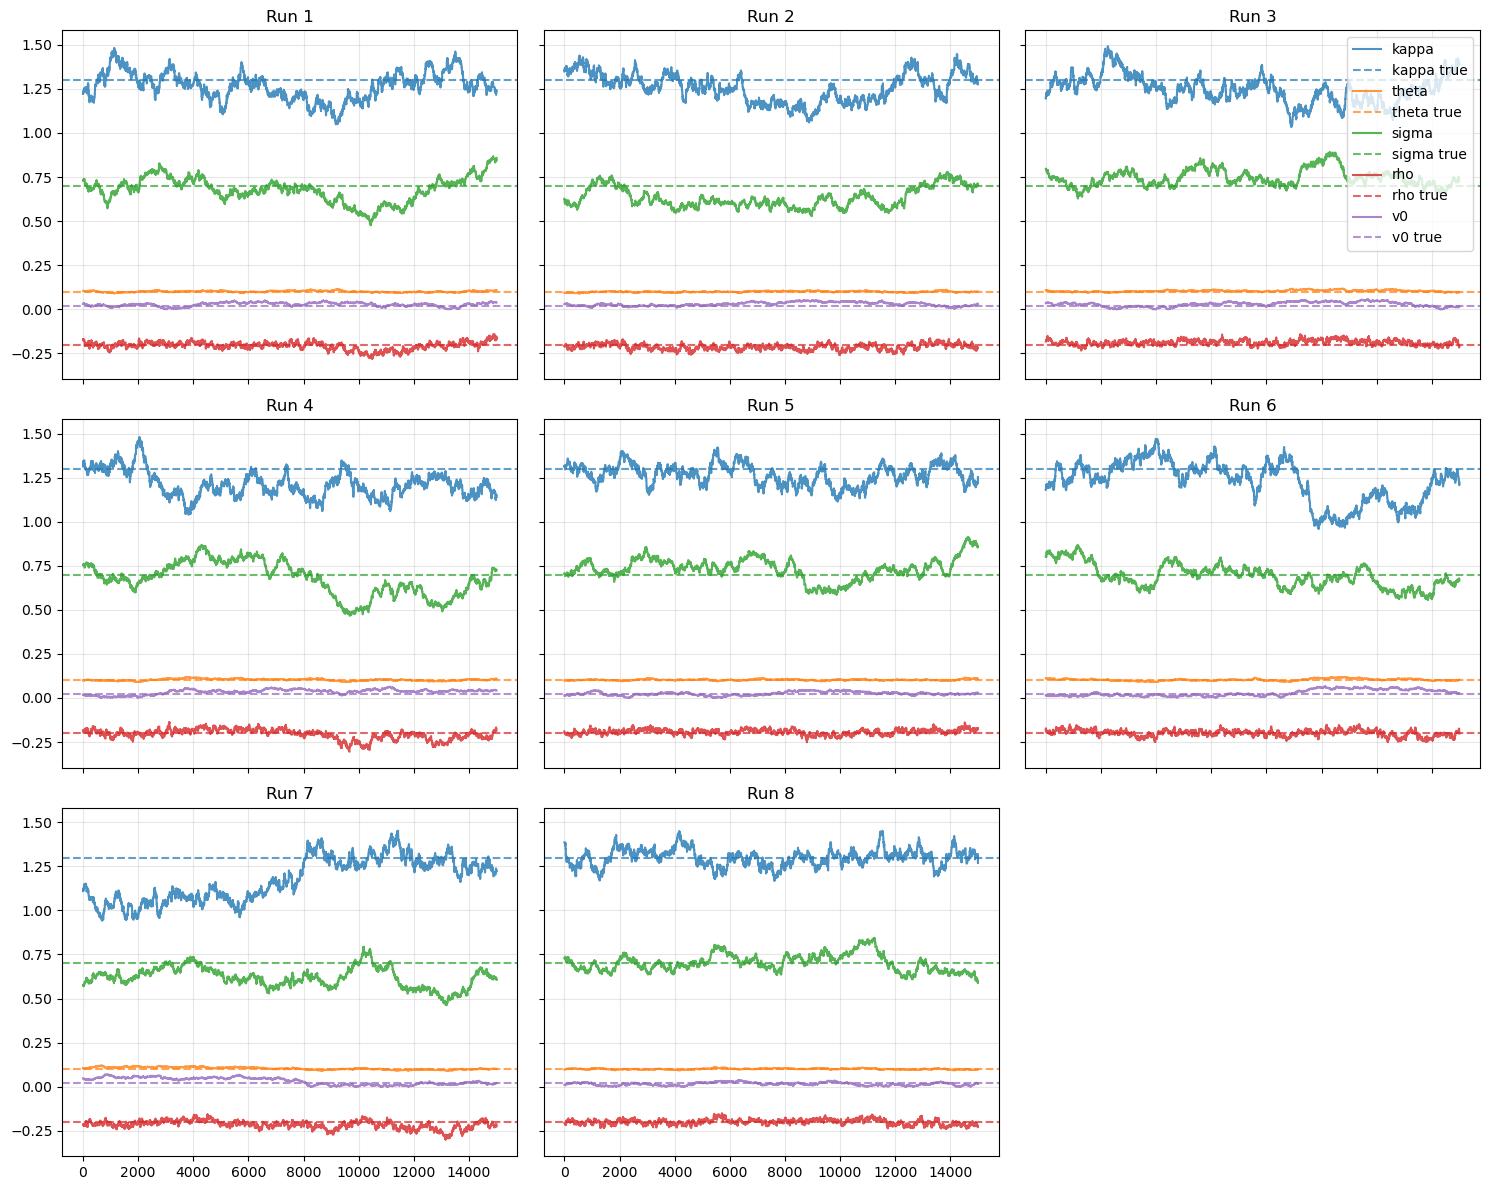

In [13]:
res.trace_plot(true_params=model_params)

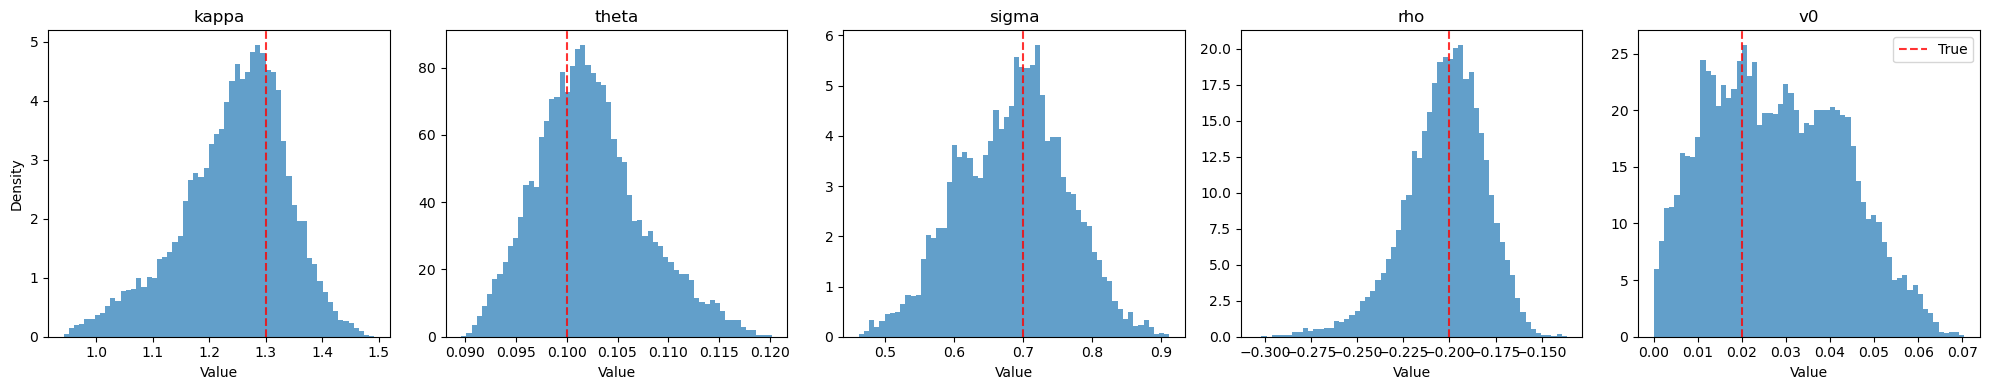

In [11]:
res.density_plot(true_params=model_params)

In [14]:
res.summary()

Average Acceptance Rate: 0.241
kappa: mean = 1.2436, std = 0.0933
theta: mean = 0.1023, std = 0.0052
sigma: mean = 0.6849, std = 0.0772
rho: mean = -0.2028, std = 0.0217
v0: mean = 0.0278, std = 0.0149

R-hat (Gelman-Rubin):
kappa: 1.2750
theta: 1.2028
sigma: 1.3487
rho: 1.1991
v0: 1.3909
